In [1]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jre-headless is already the newest version (8u275-b01-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# Read files

In [2]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
!cp '/content/drive/My Drive/application_train.csv' 'application_train.csv'
!cp '/content/drive/My Drive/previous_application.csv' 'previous_application.csv'
!cp '/content/drive/My Drive/installments_payments.csv' 'installments_payments.csv'
!cp '/content/drive/My Drive/rank.csv' 'rank.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
non_feature_columns = ["SK_ID_CURR", "label", "SK_ID_PREV"]
df_train = spark.read.csv("/content/application_train.csv",inferSchema="true", header="true").cache()
df_prev_app = spark.read.csv("/content/previous_application.csv",inferSchema="true", header="true").cache()
df_payment = spark.read.csv("/content/installments_payments.csv",inferSchema="true", header="true").cache()

df_train = df_train.withColumnRenamed('TARGET','label')

# Show Data

In [5]:
# drop columns with too many null values
to_be_dropped = []

for column in [col for col in df_train.columns if col not in non_feature_columns]:
  nan_count = df_train.filter(df_train[column].isNull()).count()
  nan_ratio = nan_count / df_train.count()
  if nan_ratio > 0.5:
    to_be_dropped.append(column)

print("Dropped", len(to_be_dropped), "columns")
df_train = df_train.drop(*to_be_dropped).cache()

Dropped 41 columns


In [6]:
# drop columns with too many null values
to_be_dropped = []

for column in [col for col in df_prev_app.columns if col not in non_feature_columns]:
  nan_count = df_prev_app.filter(df_prev_app[column].isNull()).count()
  nan_ratio = nan_count / df_prev_app.count()
  if nan_ratio > 0.5:
    to_be_dropped.append(column)

print("Dropped", len(to_be_dropped), "columns")
df_prev_app = df_prev_app.drop(*to_be_dropped).cache()

Dropped 4 columns


In [7]:
# df_train.select('label').filter("label=1").count()

In [8]:
# df_train.select('label').filter("label=0").count()

In [9]:
df_train = df_train.limit(10000).cache()

In [10]:
df_train.show()

+----------+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+---------------------------+-------------+----------------------------+--------------+----------------------------+--------------+--------------+-------------------+------------------------+------------------------+------------------------+----

# Feature Engineering

In [11]:
# Loan duration
df_train = df_train.withColumn("LOAN_DURATION", df_train["AMT_CREDIT"] / df_train["AMT_ANNUITY"]).cache()
df_prev_app = df_prev_app.withColumn("LOAN_DURATION", df_prev_app["AMT_CREDIT"] / df_prev_app["AMT_ANNUITY"]).cache()
# Since one application can have multiple previous applications
# We need to aggerate the previous application dataframe first
df_prev_app_means = df_prev_app.groupBy("SK_ID_CURR").mean("LOAN_DURATION", "AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_GOODS_PRICE", "DAYS_DECISION", "CNT_PAYMENT").cache()
df_payment_means = df_payment.groupBy("SK_ID_CURR").mean("DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT", "AMT_INSTALMENT", "AMT_PAYMENT").cache()
# joining to the master table
df_train = df_train.join(df_prev_app_means, ['SK_ID_CURR'], how='left').cache()
df_train = df_train.join(df_payment_means, ['SK_ID_CURR'], how='left').cache()
# filling nan values
df_train = df_train.na.fill(0).cache()

In [12]:
df_payment.printSchema()

root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NUM_INSTALMENT_VERSION: double (nullable = true)
 |-- NUM_INSTALMENT_NUMBER: integer (nullable = true)
 |-- DAYS_INSTALMENT: double (nullable = true)
 |-- DAYS_ENTRY_PAYMENT: double (nullable = true)
 |-- AMT_INSTALMENT: double (nullable = true)
 |-- AMT_PAYMENT: double (nullable = true)



In [13]:
len(df_train.columns)

93

In [14]:
df_train.count()

10000

# Finalized Pipeline

In [15]:
print("# Cols:" + str(len(df_train.columns)))
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=
                       [column for column in list(set(df_train.columns)) if column !='label'],
                       outputCol="indexedFeatures",
                       numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

# Split the data into training and test sets (30% held out for testing)
trainingData, testData = df_train.randomSplit([0.7, 0.3],seed = 1234)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=20, maxDepth=15)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher, rf])

rfModel = pipeline.fit(trainingData)

predictions = rfModel.transform(testData).cache()

predictions.select("prediction", "rawPrediction", "probability", "indexedLabel").show(5)

evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

predictions_rf = predictions

print("RandomForestClassifier AUC:" +str(auc))


from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter=5, regParam=0.03)
pipeline = Pipeline(stages=[labelIndexer, hasher, lr])
lrModel = pipeline.fit(trainingData)
predictions = lrModel.transform(testData).cache()

evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

predictions_lr = predictions

print("LogisticRegression AUC:" +str(auc))

from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10, maxDepth=5)
pipeline = Pipeline(stages=[labelIndexer, hasher, gbt])
gbtModel = pipeline.fit(trainingData)
predictions = gbtModel.transform(testData).cache()

evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

predictions_gbt = predictions


print("GBTClassifier AUC:" +str(auc))


# Cols:93
+----------+--------------------+--------------------+------------+
|prediction|       rawPrediction|         probability|indexedLabel|
+----------+--------------------+--------------------+------------+
|       0.0|[18.9821203020946...|[0.94910601510473...|         0.0|
|       0.0|[19.7196969696969...|[0.98598484848484...|         0.0|
|       0.0|[19.7367173087160...|[0.98683586543580...|         0.0|
|       0.0|[19.8209145739344...|[0.99104572869672...|         0.0|
|       0.0|[18.8069691645543...|[0.94034845822771...|         0.0|
+----------+--------------------+--------------------+------------+
only showing top 5 rows

RandomForestClassifier AUC:0.6199089443633433
LogisticRegression AUC:0.6603041387900961
GBTClassifier AUC:0.6465978841048593


# Ensemble

In [16]:
rf_probability = predictions_rf.select("probability", "indexedLabel").rdd.zipWithIndex().map(lambda x: (x[1], (x[0].probability.values[1], x[0].indexedLabel))).cache()
lr_probability = predictions_lr.select("probability", "indexedLabel").rdd.zipWithIndex().map(lambda x: (x[1], (x[0].probability.values[1], x[0].indexedLabel))).cache()
gbt_probability = predictions_gbt.select("probability", "indexedLabel").rdd.zipWithIndex().map(lambda x: (x[1], (x[0].probability.values[1], x[0].indexedLabel))).cache()

print(rf_probability.take(2))

[(0, (0.05089398489526904, 0.0)), (1, (0.014015151515151513, 0.0))]


In [17]:
joined = rf_probability.join(lr_probability).map(lambda x: (x[0], (x[1][0][0], x[1][1][0], x[1][0][1]))).cache()
joined = joined.join(gbt_probability).map(lambda x: (x[0], (x[1][0][0], x[1][0][1], x[1][1][0], x[1][1][1]))).cache()
joined.take(2)

[(0, (0.05089398489526904, 0.019193730239704193, 0.08055334417138205, 0.0)),
 (1200, (0.14492430413150825, 0.10956637689451622, 0.09164912083676025, 0.0))]

In [19]:
w_0 = [1/3,1/3,1/3]
w_1 = [0.2, 0.2, 0.6]
w_2 = [0.6, 0.2, 0.2]
w_3 = [0.2, 0.6, 0.2]

def f(x):
  d = {
      "index": x[0],
      "probability": float(x[1]),
       "label": float(x[2]),
  }
  return d
    

for w in [w_0, w_1, w_2, w_3]:
  ensemble = joined.map(lambda x: (x[0], x[1][0] * w[0] + x[1][1] * w[1] + x[1][2] * w[2], x[1][3]))
  ensemble_df = ensemble.map(lambda x: Row(**f(x))).toDF()
  evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
  auc_ensemble = evaluator.evaluate(ensemble_df)
  print(w)
  print("auc = " +str(auc_ensemble))

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
auc = 0.6706532276700916
[0.2, 0.2, 0.6]
auc = 0.6721644806925986
[0.6, 0.2, 0.2]
auc = 0.6503946871530102
[0.2, 0.6, 0.2]
auc = 0.677076581425891


In [20]:
# Pandas Version
w_0 = [1/3,1/3,1/3]
w_1 = [0.2, 0.2, 0.6]
w_2 = [0.6, 0.2, 0.2]
w_3 = [0.2, 0.6, 0.2]

evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_rf = evaluator.evaluate(predictions_rf)
auc_lr = evaluator.evaluate(predictions_lr)
auc_gbt = evaluator.evaluate(predictions_gbt)
print("auc = " +str(auc_rf))
print("auc = " +str(auc_lr))
print("auc = " +str(auc_gbt))
print("==================")
# to pd df to do weighting computation
rf_pd = predictions_rf.toPandas()
lr_pd = predictions_lr.toPandas()
gbt_pd = predictions_gbt.toPandas()

for w in [w_0, w_1, w_2, w_3]:
  rf_pd['probability'] = rf_pd['probability'] * w[0]
  lr_pd['probability'] = lr_pd['probability'] * w[1]
  gbt_pd['probability'] = gbt_pd['probability'] * w[2]


  rf_pd = rf_pd[['SK_ID_CURR','indexedLabel','probability']]
  lr_pd = lr_pd[['SK_ID_CURR','indexedLabel','probability']]
  gbt_pd = gbt_pd[['SK_ID_CURR','indexedLabel','probability']]
  ensembled_pd = rf_pd.merge(lr_pd, on='SK_ID_CURR', how='left')
  ensembled_pd = ensembled_pd.merge(gbt_pd, on='SK_ID_CURR', how='left')
  ensembled_pd['probability'] = ensembled_pd['probability_x']+ensembled_pd['probability_y']+ensembled_pd['probability']

  ensembled_pd = ensembled_pd[['indexedLabel', 'probability']]
  ensembled = spark.createDataFrame(ensembled_pd)
  evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="probability", metricName="areaUnderROC")
  auc_ensemble = evaluator.evaluate(ensembled)
  print(w, "auc = " +str(auc_ensemble))

auc = 0.6199089443633433
auc = 0.6603041387900961
auc = 0.6465978841048593
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] auc = 0.670676477716592
[0.2, 0.2, 0.6] auc = 0.6721687079737813
[0.6, 0.2, 0.2] auc = 0.6597700922674571
[0.2, 0.6, 0.2] auc = 0.670676477716592


# Explain Models

numTrees -  20
maxDepth -  15


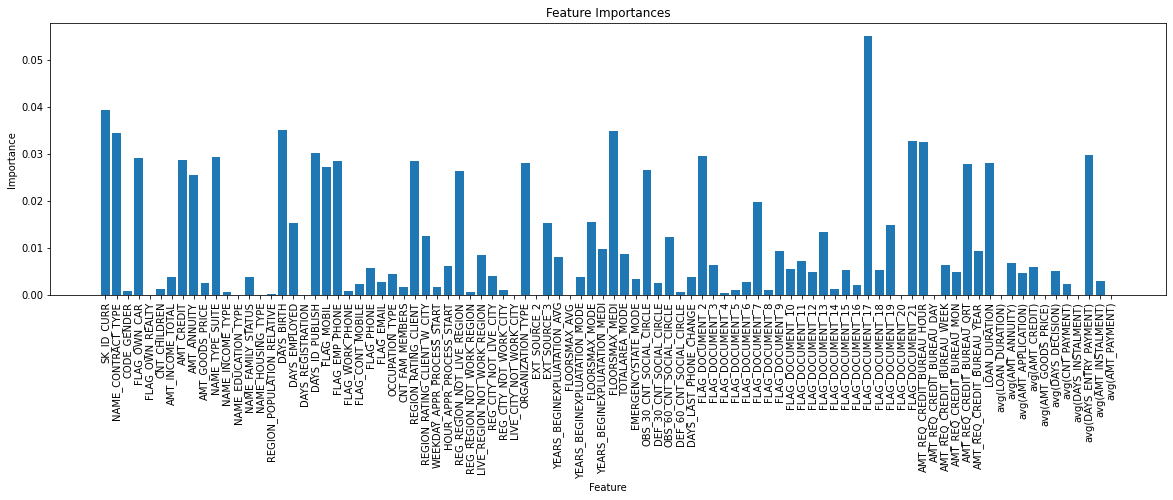

In [21]:
import matplotlib.pyplot as plt
bestModel = rfModel.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))
plt.figure(figsize=(20,5))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')


print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  10
maxDepth -  5


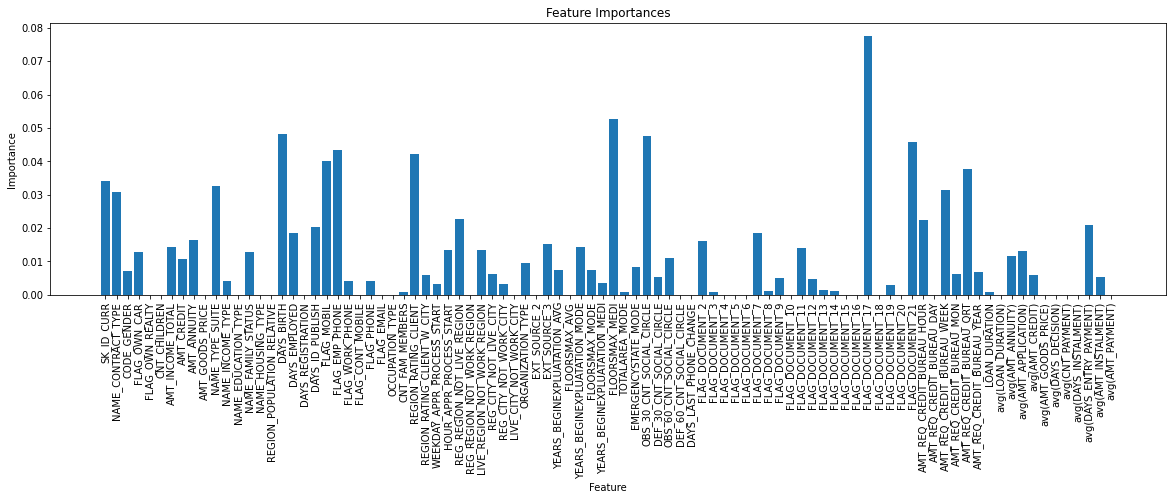

In [22]:
import matplotlib.pyplot as plt
bestModel = gbtModel.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))
plt.figure(figsize=(20,5))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')


print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

Text(0.5, 1.0, 'Feature Importances')

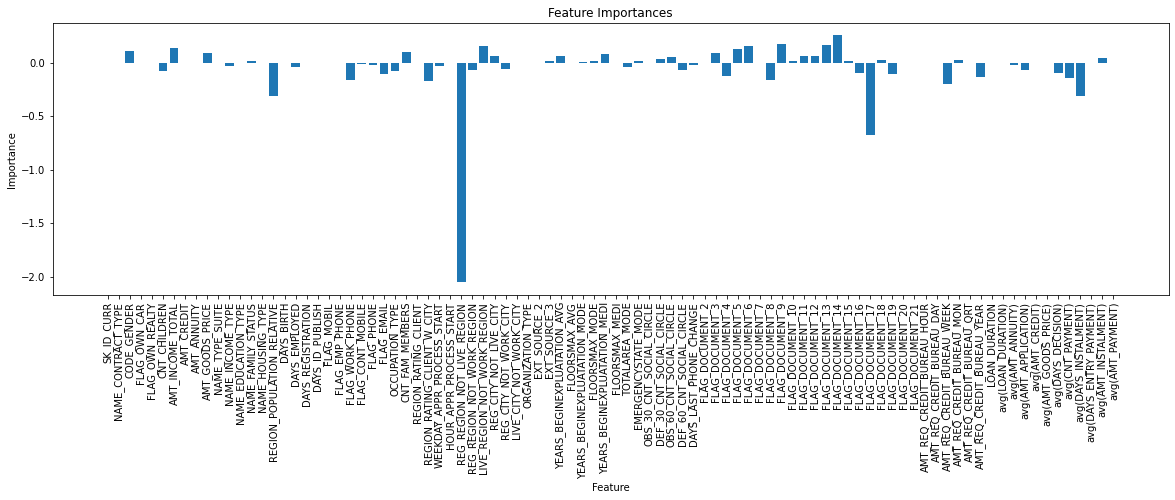

In [23]:
import matplotlib.pyplot as plt
bestModel = lrModel.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.coefficients

x_values = list(range(len(importances)))
plt.figure(figsize=(20,5))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

# Model Experiment & Optimiaztion:

In [ ]:
import numpy as np

In [ ]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=
                       [column for column in list(set(df_train.columns)) if column !='label'],
                       outputCol="indexedFeatures",
                       numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
trainingData, testData = df_train.randomSplit([0.7, 0.3],seed = 1234)

In [ ]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher, rf])

In [ ]:
model = pipeline.fit(trainingData)

In [ ]:
predictions = model.transform(testData).cache()

In [ ]:
predictions.select("prediction", "rawPrediction", "probability", "indexedLabel").show(5)

+----------+--------------------+--------------------+------------+
|prediction|       rawPrediction|         probability|indexedLabel|
+----------+--------------------+--------------------+------------+
|       0.0|[90.3696808038414...|[0.90369680803841...|         0.0|
|       0.0|[95.5023481068079...|[0.95502348106807...|         0.0|
|       0.0|[96.6102938361222...|[0.96610293836122...|         0.0|
|       0.0|[93.7542660536035...|[0.93754266053603...|         0.0|
|       0.0|[95.4100860450524...|[0.95410086045052...|         0.0|
+----------+--------------------+--------------------+------------+
only showing top 5 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))

auc = 0.6803937324226594


# RF CV

In [ ]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=
                       [column for column in list(set(df_train.columns)) if column !='label'],
                       outputCol="indexedFeatures",
                       numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

# Chain Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher])

pre_pipeline = pipeline.fit(df_train)
df_train_pre = pre_pipeline.transform(df_train).cache()

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          seed = 1234,
                          parallelism=2)

In [ ]:
cvModel = crossval.fit(df_train_pre)

In [ ]:
np.max(cvModel.avgMetrics)

0.669567309311109

numTrees -  20
maxDepth -  15


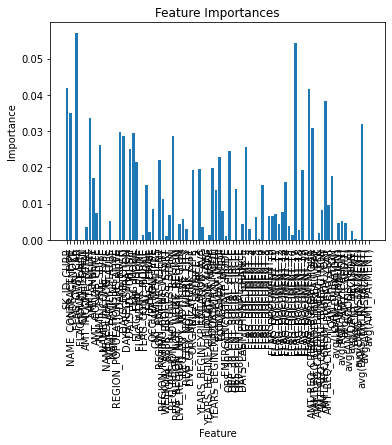

In [ ]:
import matplotlib.pyplot as plt
bestModel = cvModel.bestModel

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')


print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter=5, regParam=0.03)
pipeline = Pipeline(stages=[labelIndexer, hasher, lr])
lrModel = pipeline.fit(trainingData)
predictions = lrModel.transform(trainingData)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))


auc = 0.7764764588470121


optimize

In [ ]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=
                       [column for column in list(set(df_train.columns)) if column !='label'],
                       outputCol="indexedFeatures",
                       numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

# Chain Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher])

pre_pipeline = pipeline.fit(df_train)
df_train_pre = pre_pipeline.transform(df_train).cache()

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .addGrid(lr.regParam, [x for x in np.linspace(start = 0.01, stop = 0.5, num = 3)]) \
    .build()


lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter=5, regParam=0.03)
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

crossval = CrossValidator(estimator=lr,
              estimatorParamMaps=paramGrid,
              evaluator=evaluator,
              numFolds=3,
              seed = 1234)

In [ ]:
cvModel = crossval.fit(df_train_pre)
np.max(cvModel.avgMetrics)

0.5830199226991127

In [ ]:
import matplotlib.pyplot as plt
bestModel = cvModel.bestModel

print('maxIter - ', bestModel.getOrDefault('maxIter'))
print('regParam - {:1.15f}'.format(bestModel.getOrDefault('regParam')))

maxIter -  5
regParam - 0.030000000000000


In [ ]:
feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

weights = bestModel.coefficients
weight = [float(w) for w in weights]

In [ ]:
import pandas as pd
weight_df = pd.DataFrame(list(zip(feature_list,weight)))
weight_df[1] = weight_df[1].apply(lambda x: '%.10f' % x)

In [ ]:
weight_df

,0,1
0,SK_ID_CURR,-0.0211757729
1,NAME_CONTRACT_TYPE,-0.0000599424
2,CODE_GENDER,-0.4032634848
3,FLAG_OWN_CAR,-0.0000003306
4,FLAG_OWN_REALTY,0.0000000000
...,...,...
87,avg(CNT_PAYMENT),-0.2446039077
88,avg(DAYS_INSTALMENT),-0.4033985516
89,avg(DAYS_ENTRY_PAYMENT),-0.0000004188
90,avg(AMT_INSTALMENT),-0.0892853709


Gradient Tree boosting

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)
pipeline = Pipeline(stages=[labelIndexer, hasher, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))


auc = 0.6786862193652071


Optimize

In [ ]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=
                       [column for column in list(set(df_train.columns)) if column !='label'],
                       outputCol="indexedFeatures",
                       numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

# Chain Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher])

pre_pipeline = pipeline.fit(df_train)
df_train_pre = pre_pipeline.transform(df_train).cache()

In [ ]:
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start = 4, stop = 10, num = 3)]) \
    .addGrid(gbt.maxIter, [x for x in np.linspace(start = 10, stop = 20, num = 3)]) \
    .build()

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

crossval = CrossValidator(estimator=gbt,
              estimatorParamMaps=paramGrid,
              evaluator=evaluator,
              numFolds=3,
              seed = 1234)

In [ ]:
cvModel = crossval.fit(df_train_pre)
np.max(cvModel.avgMetrics)

0.6149568823566678

In [ ]:
bestModel = cvModel.bestModel
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('maxIter - ',bestModel.getOrDefault('maxIter'))

maxDepth -  5
maxIter -  10


In [ ]:
import matplotlib.pyplot as plt
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

ensemble the models - weighted voting

Models with optimized parameters

general

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

In [ ]:
df_train = spark.read.csv("/content/sample_data/test.csv",inferSchema="true", header="true")
df_train = df_train.withColumnRenamed('TARGET','label')
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=[column for column in list(set(df_train.columns)) if column !='label'],outputCol="indexedFeatures",numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

RF

In [ ]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees = 10, maxDepth = 25)
pipeline_rf = Pipeline(stages=[labelIndexer, hasher, rf])
model_rf = pipeline_rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)

LR

In [ ]:
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter = 20, regParam = 0.0255)
pipeline_lr = Pipeline(stages=[labelIndexer, hasher, lr])
model_lr = pipeline_lr.fit(trainingData)
predictions_lr = model_lr.transform(testData)

GBT

In [ ]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter = 10, maxDepth = 5)
pipeline_gbt = Pipeline(stages=[labelIndexer, hasher, gbt])
model_gbt = pipeline_gbt.fit(trainingData)
predictions_gbt = model_gbt.transform(testData)

Weighting

Ensemble the model

In [ ]:
rf_pd['probability'] = rf_pd['probability'] * w_1[0]
lr_pd['probability'] = lr_pd['probability'] * w_1[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_1[2]

In [ ]:
rf_pd['probability'] = rf_pd['probability'] * w_2[0]
lr_pd['probability'] = lr_pd['probability'] * w_2[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_2[2]

In [ ]:
rf_pd['probability'] = rf_pd['probability'] * w_3[0]
lr_pd['probability'] = lr_pd['probability'] * w_3[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_3[2]

In [ ]:
rf_pd['probability'] = rf_pd['probability'] * w_4[0]
lr_pd['probability'] = lr_pd['probability'] * w_4[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_4[2]

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_ensemble = evaluator.evaluate(ensembled)
print("auc = " +str(auc_ensemble))